In [1]:
import os
import pickle
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer

# Обучение модели

In [2]:
with open('./artifacts/data.csv', encoding='utf-8') as f_in:
    y = []
    texts = []
    for line in f_in:
        movie_id, sentiment, *text = line.strip('\n').split('\t')
        text = ' '.join(text)
        if sentiment == 'bad' or sentiment == 'good':
            y.append(1 if sentiment == 'good' else 0)
            texts.append(text)

In [3]:
%%time
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(texts)
print(X.shape)

(9695, 197513)
CPU times: total: 2.08 s
Wall time: 2.07 s


In [4]:
%%time
y_pred_cv = cross_val_predict(LogisticRegression(), X, y, cv=4, n_jobs=-1, verbose=True, method='predict_proba')
print('Cross-validated AUC: %.4f' % roc_auc_score(y, y_pred_cv[:,1]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.9s finished


Cross-validated AUC: 0.9388
CPU times: total: 15.6 ms
Wall time: 2.23 s


In [5]:
%%time
L = LogisticRegression(solver='lbfgs', class_weight='balanced')
L.fit(X, y)

features = tfidf.get_feature_names()
features_with_weights = pd.DataFrame(zip(features, L.coef_[0]), columns=['feature', 'weight']).sort_values('weight')

CPU times: total: 1.52 s
Wall time: 1.37 s


C:\Toolchain\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
features_with_weights

,feature,weight
96279,ничего,-4.866933
94898,нет,-4.474639
52612,зачем,-4.249763
23583,вообще,-3.814362
95820,ни,-3.549688
...,...,...
103231,он,2.834327
60689,каждый,2.987372
107470,отлично,3.017201
17,10,3.180422


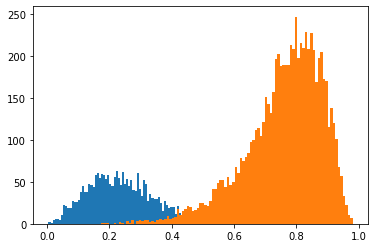

0.42424242424242425 0.9755544094894275


In [7]:
plt.hist(L.predict_proba(X[np.array(y) == 0])[:, 1], bins=100)
plt.hist(L.predict_proba(X[np.array(y) == 1])[:, 1], bins=100)
plt.show()

best_threshold, best_accuracy = 0.0, 0.0
for _ in np.linspace(0, 1, 100):
    correct_0 = np.sum(L.predict_proba(X[np.array(y) == 0])[:, 1] < _)
    correct_1 = np.sum(L.predict_proba(X[np.array(y) == 1])[:, 1] > _)
    accuracy_0 = (correct_0) / (np.sum(np.array(y) == 0))
    accuracy_1 = (correct_1) / (np.sum(np.array(y) == 1))
    accuracy = (correct_0 + correct_1) / (np.sum(np.array(y) == 0) + np.sum(np.array(y) == 1))
    if best_accuracy < accuracy:
        best_threshold, best_accuracy = _, accuracy
#     print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t".format(_, accuracy_0, accuracy_1, accuracy))
print(best_threshold, best_accuracy)

In [8]:
os.makedirs('./artifacts', exist_ok=True)
with open('./artifacts/logreg.pkl', 'wb') as f_out:
    pickle.dump(L, f_out)
with open('./artifacts/tf-idf.pkl', 'wb') as f_out:
    pickle.dump(tfidf, f_out)
with open('./artifacts/params.pkl', 'wb') as f_out:
    pickle.dump({'threshold': best_threshold}, f_out)